In [ ]:
# default_exp image_resize

# Image resize
> Resizing dataset

In [ ]:
# export

from pathlib import Path
from PIL import Image
from typing import Tuple, Optional, Dict, List, Union, Callable, Iterable

In [ ]:
# exporti

from fastcore.script import *

#import dolphins

import numpy as np
from shutil import rmtree

from dolphins_recognition_challenge.helpers import *
from tempfile import TemporaryDirectory

In [ ]:
# exporti


def _get_pallete(img_P: Image.Image) -> List[List[int]]:
    """Returns a list of colors from the input image"""
    palette = np.array(img_P.getpalette()).reshape((-1, 3)).tolist()
    palette = palette[: len(np.unique(palette, axis=0))]

    return palette

In [ ]:
# skip


fin_body_path = Path("../data/testing/fin_body_5/")

fin_body_jpeg_path = sorted(fin_body_path.glob("**/JPEGImages/*.jpg"))
fin_body_segmentation_classes_path = sorted(
    fin_body_path.glob("**/SegmentationClass/*.png")
)
fin_body_segmentation_objects_path = sorted(
    fin_body_path.glob("**/SegmentationObject/*.png")
)

assert fin_body_path.exists()
assert len(fin_body_jpeg_path) == 5
assert len(fin_body_segmentation_classes_path) == 5
assert len(fin_body_segmentation_objects_path) == 5

In [ ]:
# export


def display_image(img: Union[Image.Image, Iterable[Image.Image]], x_size=240):
    """Displays an image or multiple images"""

    if isinstance(img, Image.Image):
        y_size = int(img.size[1] / img.size[0] * x_size)
        display(img.resize((x_size, y_size)))
    else:
        for i in img:
            display_image(i, x_size=x_size)

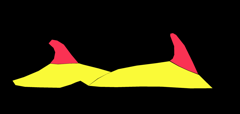

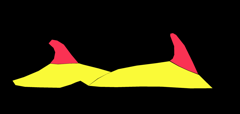

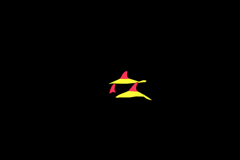

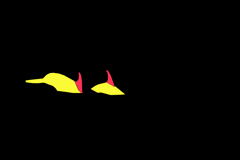

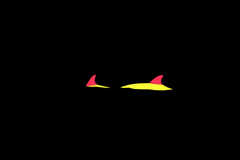

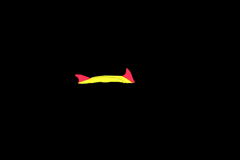

In [ ]:
# skip

imgs = [
    Image.open(fin_body_segmentation_classes_path[i])
    for i in range(len(fin_body_segmentation_classes_path))
]

display_image(imgs[0])
display_image(imgs)

In [ ]:
# skip

class_test = Image.open(fin_body_segmentation_classes_path[0])

class_test = class_test.convert(
    "P", palette=Image.ADAPTIVE, colors=len(class_test.getcolors())
)

palette = _get_pallete(class_test)
assert len(palette) == 3
palette

[[250, 250, 55], [250, 50, 83], [0, 0, 0]]

In [ ]:
# skip

instance_test = Image.open(fin_body_segmentation_objects_path[0])

instance_test = instance_test.convert(
    "P", palette=Image.ADAPTIVE, colors=len(instance_test.getcolors())
)

palette_instance = _get_pallete(instance_test)
assert len(palette_instance) >= len(palette)
palette_instance

[[128, 128, 0], [0, 128, 0], [128, 0, 0], [0, 0, 128], [0, 0, 0]]

In [ ]:
# exporti


def _separate_img(
    img: Image.Image,  # png image
    palette: List[List[int]],  # list of RGB colors
) -> List[Image.Image]:
    """Creates a list of images from the input image and color palette.
    Each image has one class and background"""

    img_array = np.array(img)
    img_separated = [
        Image.fromarray(img_array == i, mode="P") for i, color in enumerate(palette)
    ]

    black = [0, 0, 0]
    for color, im in zip(palette, img_separated):
        im.putpalette(black + color)

    return img_separated

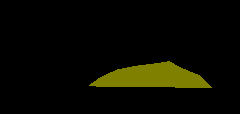

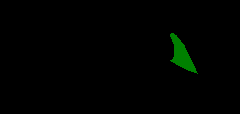

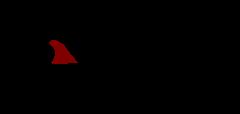

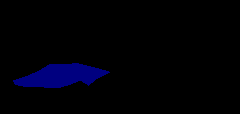

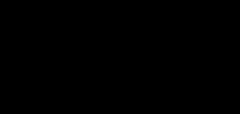

In [ ]:
# skip

display_image(_separate_img(instance_test, palette_instance))

In [ ]:
# exporti


def separate_masks(img: Image.Image) -> List[Image.Image]:
    """Converts RGB image to P. Creates a list of images from the input image.
    Each image has one class and background"""

    img_P = img.convert("P", palette=Image.ADAPTIVE, colors=len(img.getcolors()))

    palette = _get_pallete(img_P)

    return _separate_img(img_P, palette)

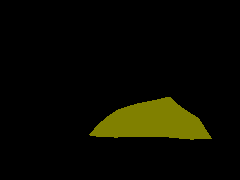

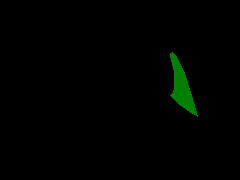

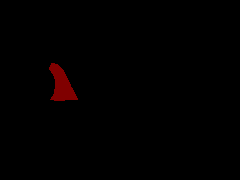

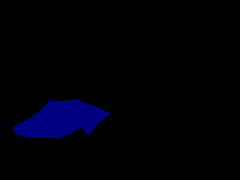

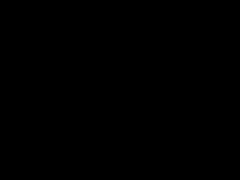

In [ ]:
# skip

for i in separate_masks(instance_test):
    display(i.resize((240, 180)))

In [ ]:
# exporti


def resize_composite_multi(img: Image.Image, image_size: Tuple) -> Image.Image:
    """Resizes images and merges images into one"""
    separated_masks = separate_masks(img)
    separated_masks_new = []
    for im in separated_masks:
        separated_masks_new.append(im.resize(image_size))

    temp_img = Image.composite(
        separated_masks_new[1].convert("RGB"),
        separated_masks_new[0].convert("RGB"),
        separated_masks_new[1].convert("L"),
    )
    if len(separated_masks_new) <= 3:
        return temp_img
    else:
        for k in range(2, len(separated_masks_new) - 1):
            temp_img = Image.composite(
                separated_masks_new[k].convert("RGB"),
                temp_img.convert("RGB"),
                separated_masks_new[k]
                .convert("L")
                .point(lambda x: 0 if x == 0 else 255, "1"),
            )
        return temp_img

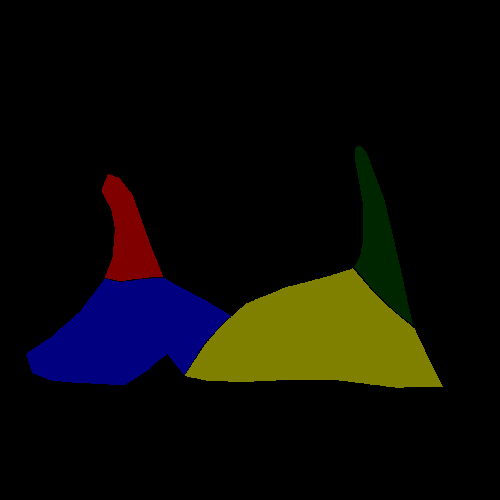

In [ ]:
# skip

resize_composite_multi(instance_test, (500, 500))

In [ ]:
# exporti


def calculate_image_size(img: Image.Image, smaller_size=1000) -> Tuple[int]:
    """Sets the smaller dimension of the image to the value of the variable smaller_size and reduces the larger dimension by the same amount"""
    x, y = img.size

    if min(x, y) == y:

        x = int(x / (y / smaller_size))
        y = smaller_size
    else:
        y = int(y / (x / smaller_size))
        x = smaller_size

    return (x, y)

In [ ]:
# skip

print(f"input shape: {instance_test.size}")
assert instance_test.size == (2664, 1274)

actual = calculate_image_size(instance_test, smaller_size=500)
expected = (1045, 500)
print(f"output shape {actual}")
assert actual == expected

input shape: (2664, 1274)
output shape (1045, 500)


In [ ]:
# exporti


def file_suffix_in(f: Path, suffixes: List[str]) -> bool:
    """Checks if the path contains a suffix"""
    return f.suffix[1:].lower() in [suffix.lower() for suffix in suffixes]

In [ ]:
# skip

assert file_suffix_in(Path("davor.JA"), ["ja", "ti"])
assert not file_suffix_in(Path("davor.JA"), ["ti"])

In [ ]:
#export


def glob_suffixes(root_path: Path, suffixes: Union[List[str], str]) -> List[Path]:
    if isinstance(suffixes, str):
        suffixes = [suffixes]
    return sorted([f for f in root_path.glob("**/*") if file_suffix_in(f, suffixes)])

In [ ]:
# skip

assert len(glob_suffixes(fin_body_path, ["jpg", "jpeg"])) == 5
assert len(glob_suffixes(fin_body_path, "png")) == 10

In [ ]:
#  exporti


def get_files_from_path(src_path: Path) -> (Path, Path, Path):
    """Returns three lists of files from the input directory"""
    src_images_path = Path(src_path / "JPEGImages/")
    src_class_path = Path(src_path / "SegmentationClass/")
    src_instance_path = Path(src_path / "SegmentationObject/")

    ensure_exists(src_images_path)
    ensure_exists(src_class_path)
    ensure_exists(src_instance_path)

    src_images = glob_suffixes(src_images_path, ("jpg", "jpeg"))
    src_lbl_classes = glob_suffixes(src_class_path, "png")
    src_lbl_instances = glob_suffixes(src_instance_path, "png")

    return src_images, src_lbl_classes, src_lbl_instances

In [ ]:
# skip

src_images, src_lbl_classes, src_lbl_instances = get_files_from_path(fin_body_path)
for p in [src_images, src_lbl_classes, src_lbl_instances]:
    assert len(p) == 5
    for f in p:
        assert f.exists()
        assert f.is_file()

In [ ]:
# exporti


def recreate_dst_dir(dst_path: Path) -> (Path, Path, Path):
    """Deletes and recreates the directory and returns 3 dst paths"""
    dst_images_path = Path(dst_path / "JPEGImages")
    dst_class_path = Path(dst_path / "SegmentationClass")
    dst_instance_path = Path(dst_path / "SegmentationObject")

    rmtree(dst_images_path, ignore_errors=True)
    rmtree(dst_class_path, ignore_errors=True)
    rmtree(dst_instance_path, ignore_errors=True)

    dst_images_path.mkdir(parents=True, exist_ok=True)
    dst_class_path.mkdir(parents=True, exist_ok=True)
    dst_instance_path.mkdir(parents=True, exist_ok=True)

    return dst_images_path, dst_class_path, dst_instance_path

In [ ]:
# skip

# prazan dir i onda ga napravim
with TemporaryDirectory() as d:
    dst_path = Path(d)
    recreate_dst_dir(dst_path)
    assert dst_path.exists()
    assert dst_path.is_dir()
    dir_found = list(dst_path.glob("**/*"))
    assert len(dir_found) == 3
    for dst_subpath in dir_found:
        assert dst_subpath.is_dir()
        assert dst_subpath.name in [
            "JPEGImages",
            "SegmentationClass",
            "SegmentationObject",
        ]


# puni dir i onda ga izbrisem
with TemporaryDirectory() as d:
    dst_path = Path(d)
    (dst_path / "JPEGImages" / "random").mkdir(parents=True)

    recreate_dst_dir(dst_path)
    assert dst_path.exists()
    assert dst_path.is_dir()
    dir_found = list(dst_path.glob("**/*"))
    assert len(dir_found) == 3, f"{dir_found}"
    for dst_subpath in dir_found:
        assert dst_subpath.is_dir()
        assert dst_subpath.name in [
            "JPEGImages",
            "SegmentationClass",
            "SegmentationObject",
        ]

In [ ]:
# exporti


def save_img_lbl_inst(
    src_img_file,
    src_class_file,
    src_instance_file,
    dst_images_path,
    dst_class_path,
    dst_instance_path,
    smaller_size=1000,
):
    """Resizes images from the src directories and saves them to the dst directories"""

    lbl = Image.open(src_class_file)
    image_size = calculate_image_size(lbl, smaller_size)
    lbl = resize_composite_multi(lbl, image_size)

    inst = Image.open(src_instance_file)
    inst = resize_composite_multi(inst, image_size)

    img = Image.open(src_img_file)
    img = img.resize(image_size)

    dst_img_file = dst_images_path / src_img_file.name
    dst_class_file = dst_class_path / src_class_file.name
    dst_instance_file = dst_instance_path / src_instance_file.name

    img.save(dst_img_file)
    lbl.save(dst_class_file)
    inst.save(dst_instance_file)

In [ ]:
# export


@call_parse
def resize_dataset(
    src_path: Param("input directory containing images and annotations", Path),
    dst_path: Param("output directory, will be deleted if not empy", Path),
    dst_image_size: Param("min height or width", int) = 1000,
    verbose: Param("", bool) = True,
):

    """Resizes the entire dataset and saves it"""

    src_images, src_lbl_classes, src_lbl_instances = get_files_from_path(src_path)

    for src_img_path, src_class_path, src_instance_path in zip(
        src_images, src_lbl_classes, src_lbl_instances
    ):
        ensure_equal(src_img_path.stem, src_class_path.stem)
        ensure_equal(src_img_path.stem, src_instance_path.stem)

    dst_images_path, dst_class_path, dst_instance_path = recreate_dst_dir(dst_path)

    n = len(src_images)
    print(f"Resizing images and annotation masks in: {src_path.resolve()}")
    for i, (src_img_file, src_class_file, src_instance_file) in enumerate(
        zip(src_images, src_lbl_classes, src_lbl_instances)
    ):
        if verbose:
            print(f" - [{i+1}/{n}] {src_img_file.name}...")

        save_img_lbl_inst(
            src_img_file,
            src_class_file,
            src_instance_file,
            dst_images_path,
            dst_class_path,
            dst_instance_path,
        )

In [ ]:
# skip


with TemporaryDirectory() as dst_path:
    dst_path = Path(dst_path)

    src_path = fin_body_path

    dst_image_size = 500

    resize_dataset(src_path, dst_path, dst_image_size)

    assert len(glob_suffixes(dst_path, ["jpg", "jpeg"])) == 5
    assert len(glob_suffixes(dst_path, "png")) == 10

Resizing images and annotation masks in: /tf/airt/data/testing/fin_body_5
 - [1/5] 0706_Dino_070618_1_2_0061.jpg...
 - [2/5] 140810_33_1_0224.jpg...
 - [3/5] 150828_98_1_0036.jpg...
 - [4/5] 170720_16_1_0069.jpg...
 - [5/5] 190809_35_1_0122.jpg...
